In [1]:
# Operator Learning via Kernel Methods
#
# This is mostly a script for prototyping methods

In [2]:
# Imports
import numpy as np
import sklearn as skl
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.kernel_ridge import KernelRidge
import sys
sys.path.append('./')
from KLearn import *
from functools import reduce
import matplotlib.pyplot as plt

In [3]:
# Define some Kernels
gamma = 50;
K = lambda y1,y2 : rbf_kernel(y1,y2, gamma = gamma)
S = lambda x1,x2 : rbf_kernel(x1.T,x2.T, gamma = 0.00001) # lame, for now

In [4]:
### Generating Data

## GP kernel

def gp_kernel(t, sigma):
  return np.exp( - (1/(2*sigma**2))*t**2)

N_mesh = 100
x = np.linspace(0,1, N_mesh) # fine grid for visualization

## compute pairwise distance matrix

dist_matrix = pairwise_distances( x.reshape(-1,1), x.reshape(-1,1))

## GP lengthscale
sigma = 0.1
Cov_matrix = gp_kernel(dist_matrix, sigma) + 1e-8*np.eye(N_mesh)
Cov_matrix = 1/2*(Cov_matrix + Cov_matrix.T)

Cov_matrix_sqrt = np.linalg.cholesky(Cov_matrix)

In [5]:
## Training and test functions

N_train = 1000    # Number of training functions
N_test  = 5     # Number of testing functions
u_train = np.zeros((N_mesh, N_train))
u_test  = np.zeros((N_mesh, N_test))

for i in range(N_train):
  xi = np.random.randn(N_mesh)
  u_train[:, i] = np.dot(Cov_matrix_sqrt, xi)

for i in range(N_test):
  xi = np.random.randn(N_mesh)
  u_test [:, i] = np.dot(Cov_matrix_sqrt, xi)

# define pointwise operator

def op_square(u):
  return u**2

def op_sin(u):
    return np.sin(u)

def op_I(u):
    return u

v_train = op_square(u_train)
v_test  = op_square(u_test)

In [6]:
# Finish setting up
U = u_train;
V = v_train;
Y = x.reshape((-1, 1));

print(np.shape(U))
print(np.shape(V))
print(np.shape(Y))

(100, 1000)
(100, 1000)
(100, 1)


In [7]:
# LEARN!
D,f = KLearn(U,V,N_mesh,S,K,Y)

In [8]:
# Does it work... ?
v_mod = D(u_test);
np.max(np.abs(v_mod(Y) - v_test)) # very nice...

0.048441427798954884

In [23]:
# Define some Kernels again (this time, parameterized)
K_ = lambda g: (lambda y1,y2 : rbf_kernel(y1,y2, gamma = g))
S_ = lambda s : (lambda x1,x2 : rbf_kernel(x1,x2, gamma = s)) # lame, for now
kgrid = np.linspace(10,200, 100)
sgrid = 1/np.power(1.8,range(1,50))

In [24]:
# LEARN AGAIN!
D2,scores = OpLearn(U,V, S_,sgrid, K_, kgrid,Y, report_scores=True)
print(scores) # THESE ARE THE CV SCORES (currently rel. MSE)

Optimal gamma = 4.57475049960182e-05
[0.012207641696634804, 0.012177377834278899, 0.01191718637266193, 0.010780388356001376, 0.008630823952115585, 0.006241756176682078, 0.004160170002075136, 0.0025484946446846673, 0.0014338753614502075, 0.000767100779011285, 0.00041598475709185014, 0.00023737991765192094, 0.00014315488552423225, 9.383051350817832e-05, 7.15131084712094e-05, 6.108675710717249e-05, 5.5616853476663885e-05, 6.404592032949676e-05, 9.306372446012466e-05, 0.00014872915219681893, 0.0002496738631062559, 0.0004251857235437105, 0.0007232688888214017, 0.0012303782907208706, 0.002084785657018302, 0.0034524711096735614, 0.005387269440157571, 0.00748578256548634, 0.008979769680582285, 0.009680439180811283, 0.00993260131542979, 0.010011617355334478, 0.010033136499688105, 0.010036526651681093, 0.010034250148964027, 0.010030129220715802, 0.01002537049140563, 0.010020411731239277, 0.010015397273277448, 0.010010278795003316, 0.01000487120336099, 0.009998921918131606, 0.009992189863638524, 

[Text(0.5, 0, 'gamma for K'),
 Text(0, 0.5, 'cv score'),
 Text(0.5, 1.0, 'Parameter tuning')]

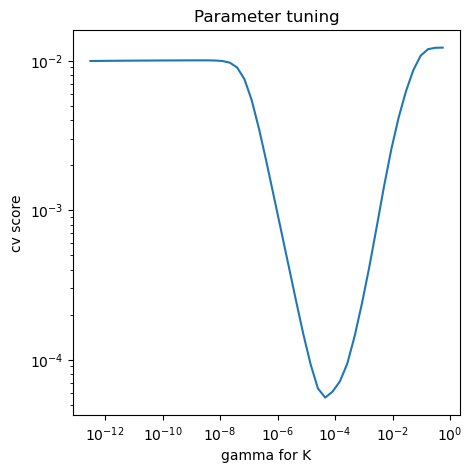

In [26]:
# Let's plot the errors
fig, ax = plt.subplots(1,1)
fig.set_size_inches(5,5)
ax.loglog(sgrid, scores)
ax.set( xlabel ='gamma for K', ylabel='cv score', title = "Parameter tuning")

In [11]:
# Does it work... ?
v_mod2 = D2(u_test);
np.max(np.abs(v_mod2(Y) - v_test)) # very nice...

Optimal gamma = 81.01010101010101


0.018005664818532274

[Text(0.5, 0, 'x'), Text(0, 0.5, 'v_i(x)'), Text(0.5, 1.0, 'CV-trained Error')]

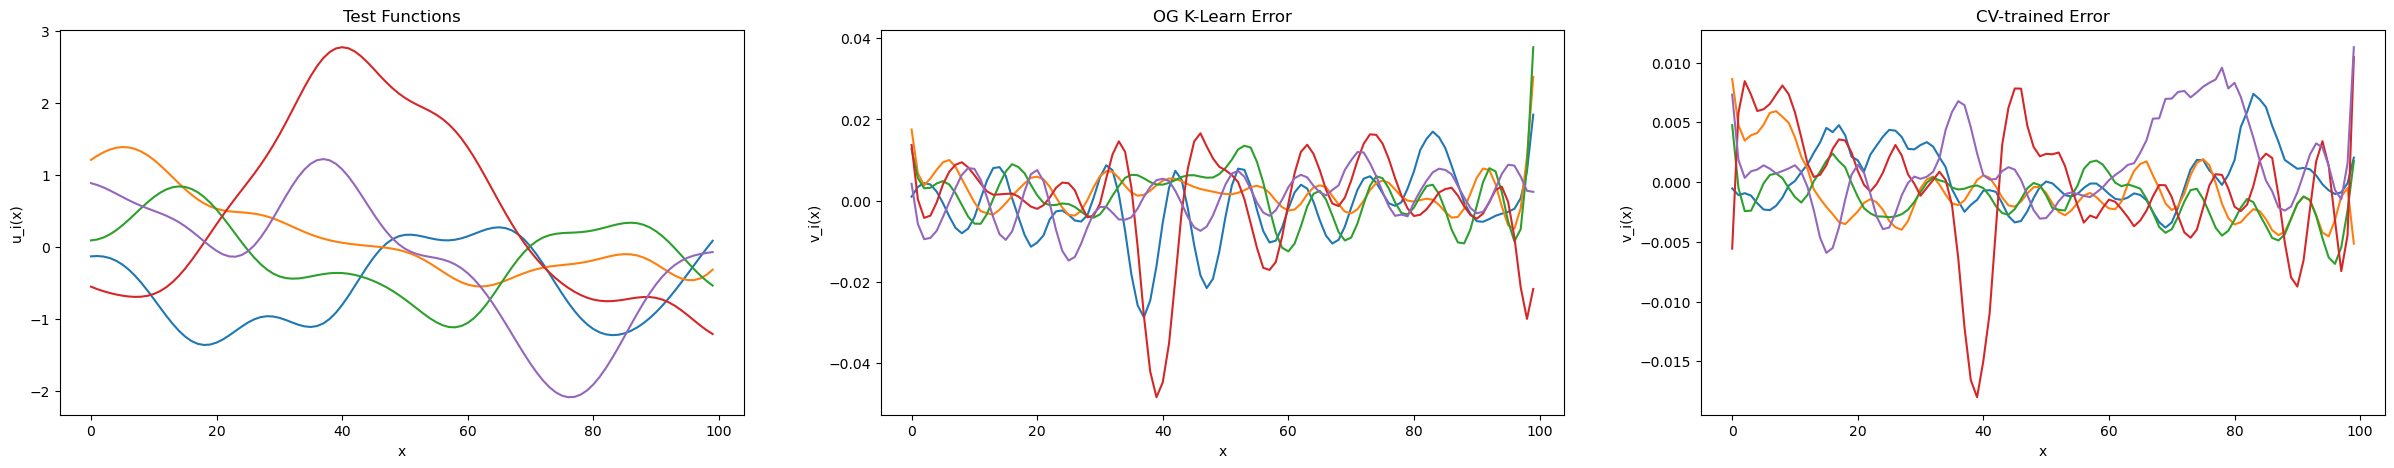

In [12]:
fig, ax = plt.subplots(1,3)

fig.set_size_inches(30,5)

ax[0].plot(u_test)
ax[0].set( xlabel ='x', ylabel='u_i(x)', title = "Test Functions")

ax[1].plot(v_mod(Y)-v_test)
ax[1].set( xlabel ='x', ylabel='v_i(x)' , title = "OG K-Learn Error")

ax[2].plot(v_mod2(Y)-v_test)
ax[2].set( xlabel ='x', ylabel='v_i(x)' , title = "CV-trained Error")


#ax[0].plot(u_train)
#ax[0].set( xlabel ='x', ylabel='u_i(x)' )

#ax[1].plot(v_train)
#ax[1].set( xlabel ='x', ylabel='v_i(x)' )

#ax[2].plot(u_test)
#ax[2].set( xlabel ='x', ylabel='u_i(x)' )

#ax[3].plot(v_test)
#ax[3].set( xlabel ='x', ylabel='v_i(x)' )